### Prueba 1 - Hito 2 - Javier Rojas Benitez - G56

In [23]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


import funciones_auxiliares_hito_2 as aux

sns.set_style()
plt.rcParams["figure.figsize"] = (20, 10)

In [24]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")

# Analisis Exploratorio

## Vector Objetivo

- En el hito 1 se abordo todo el analisis exploratorio del vector objetivo. Debido a lo anterior,
se obviara esta seccion en el cuadernillo.

## Variables independientes

- En este caso, se quiere ver las palabras mas frecuentes en el conjunto de datos sin procesar.

<Axes: xlabel='conteo', ylabel='palabra'>

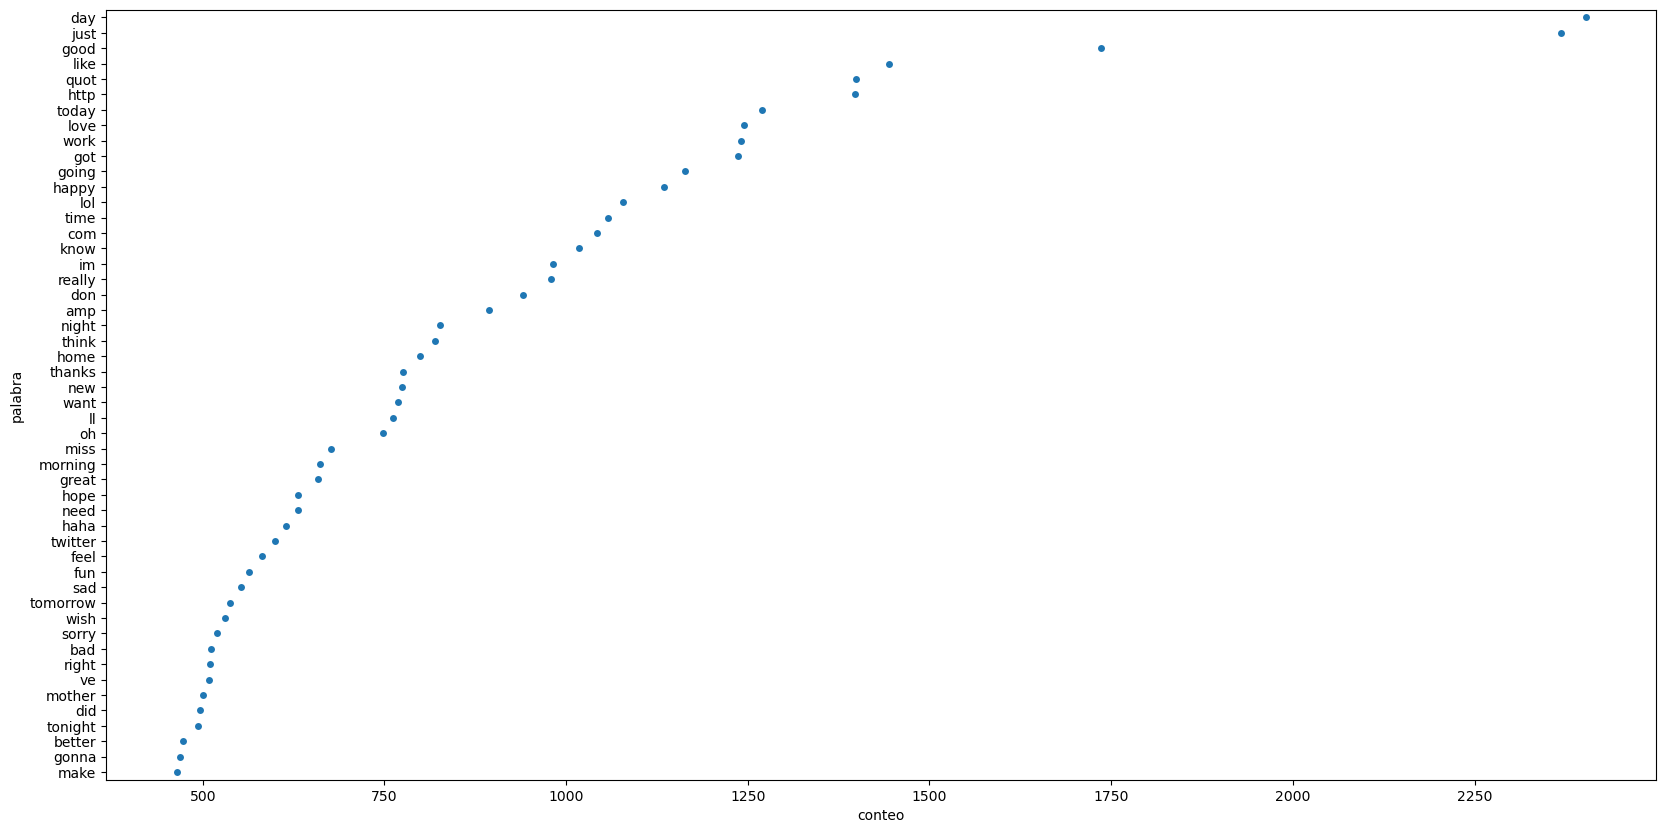

In [25]:
frecuencia_normal = aux.obtener_100_palabras_mas_frecuentes(df["content"])
sns.stripplot(data=frecuencia_normal.head(50), x="conteo", y="palabra")


- De forma general se puede ver que las 50 palabras mas frecuentes presentan una frecuencia
mayor a 500 ocurrenicas.
- Los resultados sin procesamiento se discutiran mas en detalle durante el feature engineering
de las variables independientes.

# Feature Engineering

## Vector Objetivo

- En el hito 1 se abordo todo el preprocesamiento del vector objetivo. Debido a lo anterior,
se obviara esta seccion en el cuadernillo.

In [26]:
df["sentiment"] = aux.codificar_sentimientos(df["sentiment"])



## Variables independientes

- En este apartado se quiere utilizar la lematizacion o stemming de palabras, para asi disminuir
la cantidad de palabras a utilizar en los modelos.

In [27]:
df["procesados_lema"] = df.content.str.lower().apply(aux.preprocesar_texto_lema)
df["procesados_stem"] = df.content.str.lower().apply(aux.preprocesar_texto_stem)

df_lema = aux.obtener_100_palabras_mas_frecuentes(df["procesados_lema"])
df_stem = aux.obtener_100_palabras_mas_frecuentes(df["procesados_stem"])


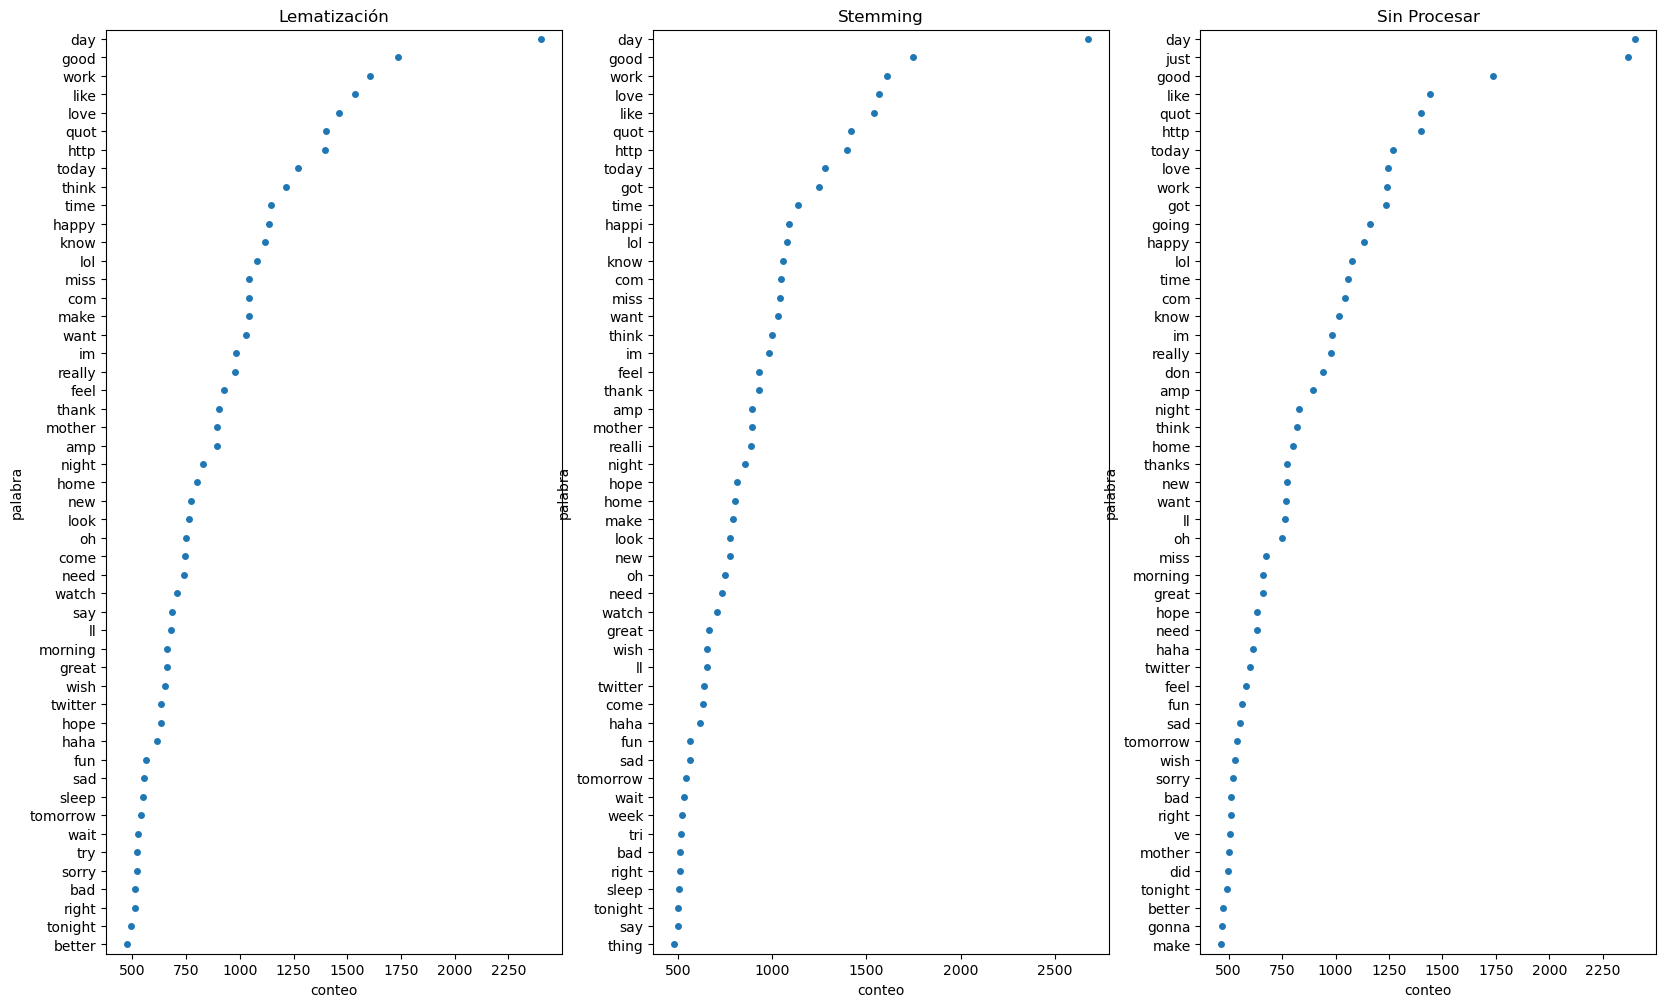

La cantidad de palabras distintas en la lematizacion fue: 37681
La cantidad de palabras distintas en el stemming fue: 37497
La cantidad de palabras distintas sin procesar fue: 39315


In [28]:
figure, axis = plt.subplots(1, 3, figsize=(20, 12))

sns.stripplot(data=df_lema.head(50), x="conteo", y="palabra", ax=axis[0])
sns.stripplot(data=df_stem.head(50), x="conteo", y="palabra", ax=axis[1])
sns.stripplot(data=frecuencia_normal.head(50), x="conteo", y="palabra", ax=axis[2])
axis[0].set_title("Lematización")
axis[1].set_title("Stemming")
axis[2].set_title("Sin Procesar")
plt.show()


print(f"La cantidad de palabras distintas en la lematizacion fue: {df_lema.shape[0]}")
print(f"La cantidad de palabras distintas en el stemming fue: {df_stem.shape[0]}")
print(f"La cantidad de palabras distintas sin procesar fue: {frecuencia_normal.shape[0]}")

- La lematizacion y stemming presentaron un menor numero de palabras que los cuerpos de texto
sin procesar (37681, 37497 y 39314, respectivamente). Por lo tanto, si se esta reduciendo la dimensionalidad o variedad de palabras.

- La lematización y el stemming presentaron un patrón de palabras bastante similares entre sí.

- Si nos basamos en la cantidad de palabras distintas brindadas por cada aproximacion, entonces el stemming es la mejor táctica para preprocesar el texto. 
Esto, ya que el modelo será más parsimonioso.

- La representación de las palabras con la lematización es más fiel al lenguaje que el stemming.
Ejemplos de este fenómeno ocurre con las siguientes palabras:

|Lematización|Stemming|
|-----------|--------|
happy|happi|
really|realli|

- Teniendo en cuenta todos los resultados previos, **se utilizará la técnica de lematización para la
confección de cada modelo**. Esto, porque tiene una mejor interpretación de los datos, a pesar de
ser más costoso computacionalmente.

## Division de Muestra

In [29]:
X = CountVectorizer(stop_words="english").fit_transform(df["procesados_lema"])
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.335, random_state=1)


# Modelacion

- Se declararan todas las grillas y modelos. Sin embargo, solamente se entrenaran los modelos
logistico y naive bayes.

## Declaracion de Grillas y Modelos

In [30]:
grilla_logistic = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

grilla_naive_bayes = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "fit_prior": [True, False],
}

grilla_arbol_clasificacion = {
    "max_depth": range(3, 11),
    "max_leaf_nodes": range(1, 6),
    "criterion": ["gini", "entropy"],
}

grilla_random_forest = {
    "max_depth": range(5, 11),
    "n_estimators": range(500, 1001, 100),
    "max_features": ["sqrt", "log2"],
}

grilla_gradient_boosting = {
    "max_depth": range(5, 11),
    "learning_rate": [0.001, 0.01, 0.1, 1],
}


modelo_logistic = GridSearchCV(
    LogisticRegression(),
    grilla_logistic,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

modelo_arbol = GridSearchCV(
    DecisionTreeClassifier(),
    grilla_arbol_clasificacion,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

modelo_random_forest = GridSearchCV(
    RandomForestClassifier(), grilla_random_forest, cv=5, scoring="accuracy", n_jobs=-1
)


modelo_naive_bayes = GridSearchCV(
    MultinomialNB(), grilla_naive_bayes, cv=5, scoring="accuracy", n_jobs=-1
)

modelo_gradient_boosting = GridSearchCV(
    GradientBoostingClassifier(),
    grilla_gradient_boosting,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

## Entrenamiento de los modelos

--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


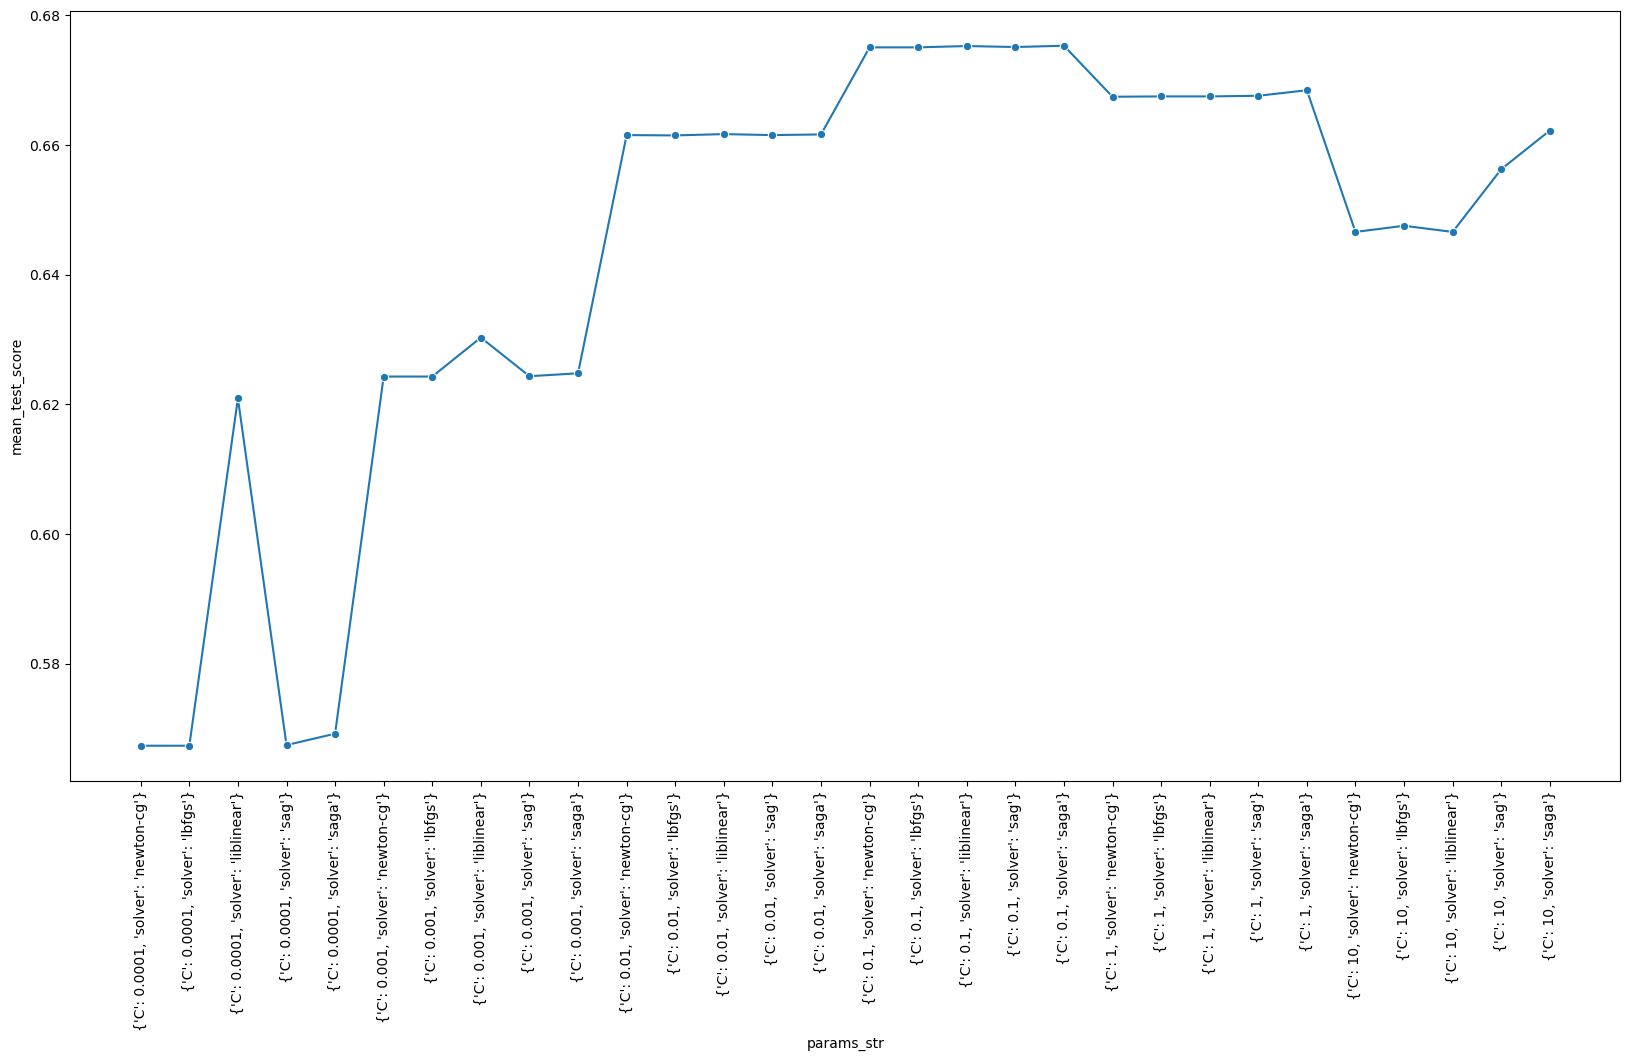

Los mejores parametros fueron: {'C': 0.1, 'solver': 'saga'}
El mejor desempeno fue: 0.6753383458646617


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      5175
           1       0.67      0.62      0.64      4875

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.668398364920104
---------------------------------------------------------------------


In [31]:
modelo_logistic.fit(X_train, y_train)
resultados_logistic = aux.obtener_desempeno_modelo_en_grilla(modelo_logistic, X_test, y_test)


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


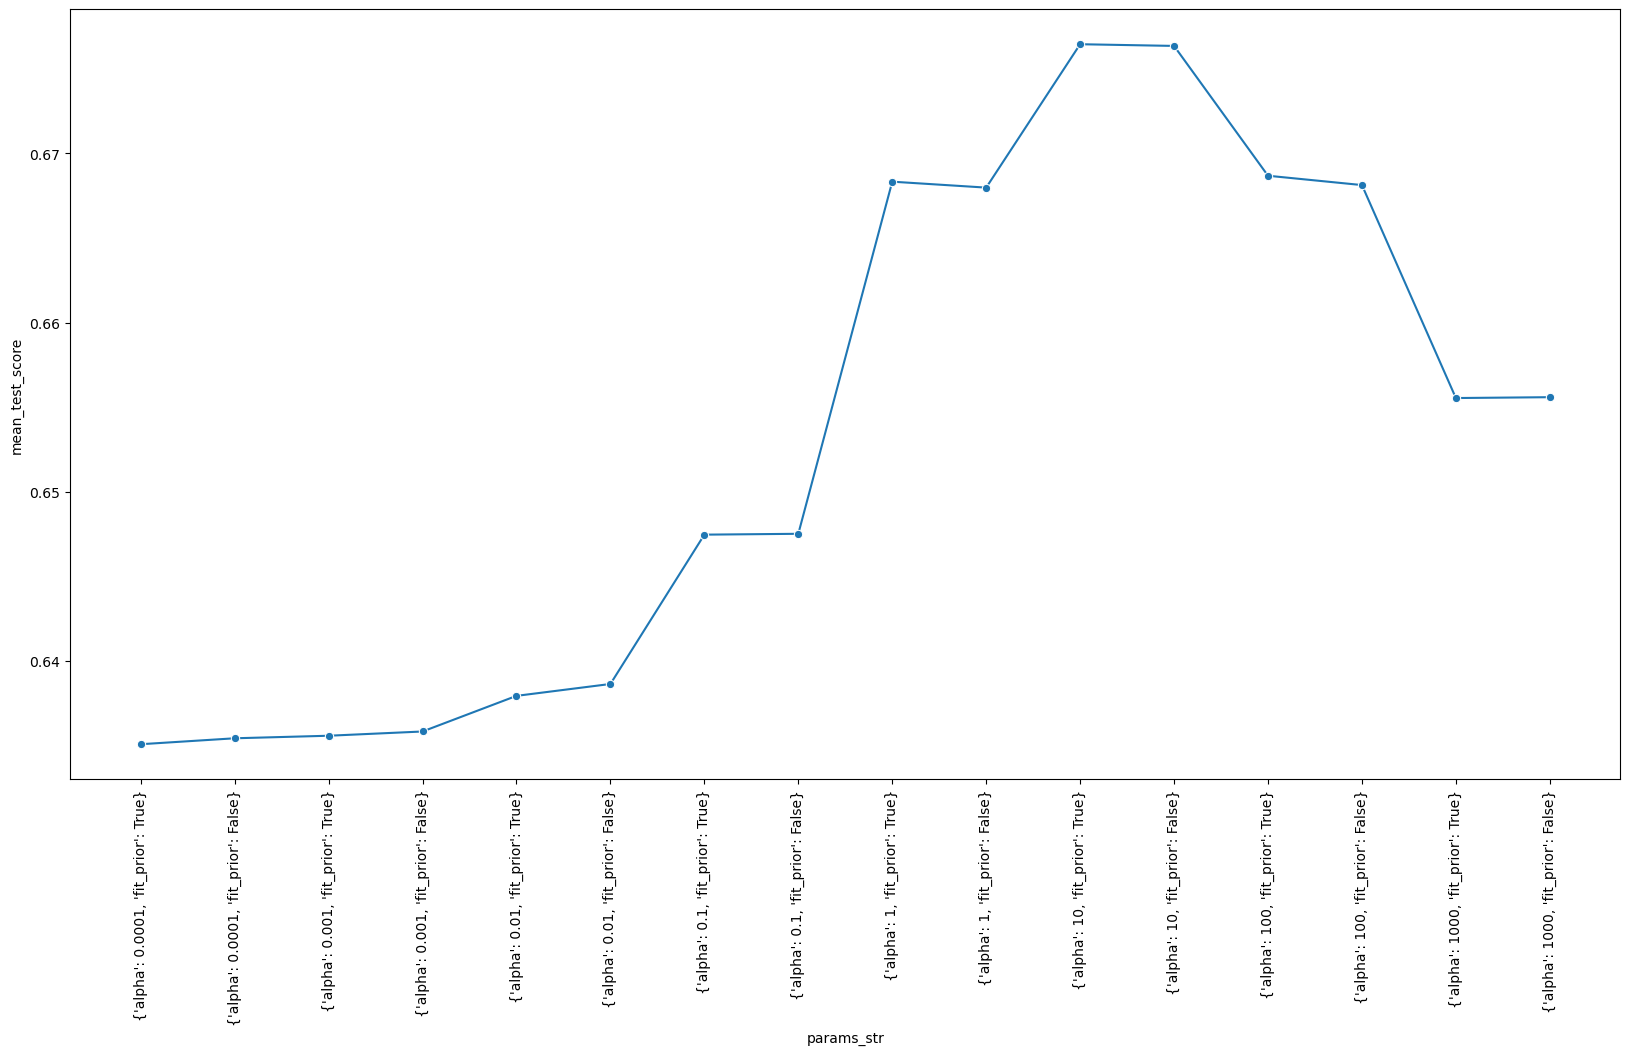

Los mejores parametros fueron: {'alpha': 10, 'fit_prior': True}
El mejor desempeno fue: 0.6764411027568922


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      5175
           1       0.66      0.67      0.67      4875

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6740274990709773
---------------------------------------------------------------------


In [32]:
modelo_naive_bayes.fit(X_train, y_train)
resultados_naive_bayes = aux.obtener_desempeno_modelo_en_grilla(modelo_naive_bayes, X_test, y_test)


## Exportacion de modelos entrenados

In [33]:
diccionario_exportacion = {
    "javier_rojas-modelo-1.pickle": modelo_logistic,
    "javier_rojas-modelo-2.pickle": modelo_naive_bayes,
}

for nombre_archivo, modelo in diccionario_exportacion.items():
    with open(nombre_archivo, "wb") as file:
        pickle.dump(modelo, file)
